<h2 align='center'>Open in<a href="https://www.kaggle.com/aksesssche/hw2-simpsons-classifier" target="_parent"><img src="https://pbs.twimg.com/media/DVEVzV8V4AAVwFn.jpg" alt="Open In Kaggle" width=100 height=100/></a></h2>

# Домашнее задание 2

## Подготовка датасета

### Импорт библиотек

In [ ]:
#!pip install tensorflow-gpu

In [1]:
import numpy as np
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

### Загрузка датасета

In [3]:
#@title
def load_data_from_np(folder_path, classes = None, verbose = 1):
    '''
    Загрузит множество npy файлов и объединит. (X, y)

    Parameters:
    
      folder_path (string): Путь до директории с файлами (Заканчивается именем папки)

      classes (list[string]): Названия классов, которые необходимо загружать
            Если None то загрузит все
  
      verbose (int): Если 1 то выводит логи. 0 - иначе
  '''
    X, y = None, []
    start_time = time.time()

    for file_path in glob.glob(folder_path + '/*.*'):
        class_name = file_path.split('/')[-1].split('.')[0]
        if ((classes == None) or (class_name in classes)):
            if (X is None):
                X = np.load(file_path)
                y = np.array([class_name]*X.shape[0])
            else:
                X_temp = np.load(file_path)
                X = np.concatenate((X, X_temp))
                y = np.concatenate((y, np.array([class_name]*X_temp.shape[0])))
      
        if (verbose == 1):
            #print('{} loaded. Total time {}'.format(class_name, time.time() - start_time))
            print('%-25s Total time: %-4f'%(class_name, time.time() - start_time))
    print('\nDone')
    return (X, np.array(y))

In [4]:
GLOBAL_PATH = '/content/drive/My Drive/Colab Notebooks/hw'
DATA_PATH = '../input/simpsons-train-numpy-my/np_images/train'
INPUT_PATH = '../input'
n_classes = 7

In [5]:
X, y = load_data_from_np(DATA_PATH, classes=['bart_simpson', 'marge_simpson', 'lisa_simpson', 'krusty_the_clown',
                                             'homer', 'abraham_grampa_simpson', 'maggie_simpson'])

lisa_simpson              Total time: 0.083038
bart_simpson              Total time: 0.212933
marge_simpson             Total time: 0.273265
homer                     Total time: 0.474201
maggie_simpson            Total time: 0.580100
krusty_the_clown          Total time: 0.756599
abraham_grampa_simpson    Total time: 0.938539

Done


### Преобразуем датасет

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))
map_characters = {i : ohe.categories_[0][i] for i in range(n_classes) }


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

## Изобразим наши данные

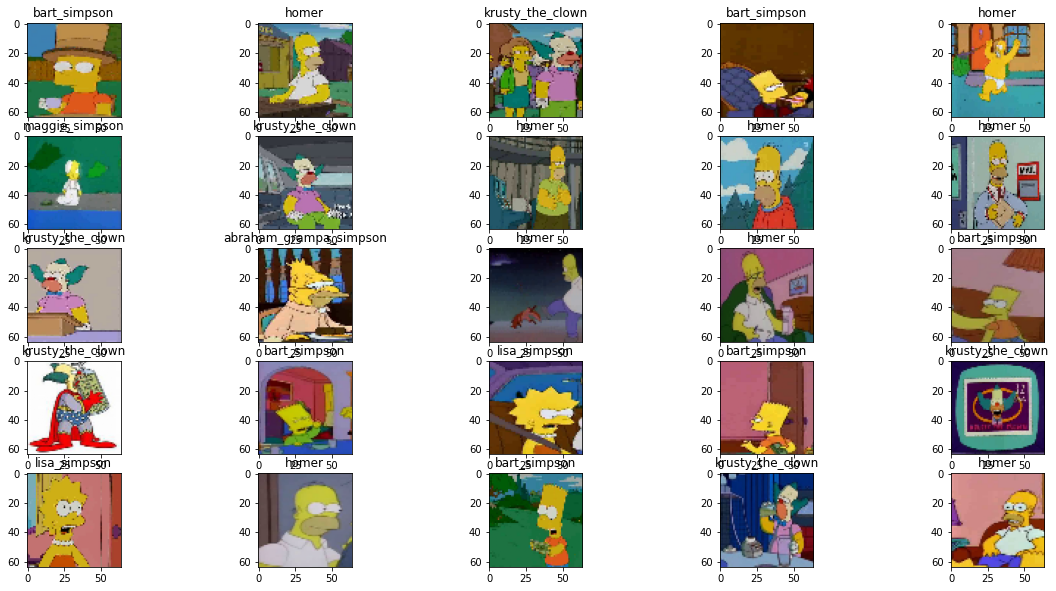

In [7]:
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    n = np.random.choice(X.shape[0])
    
    plt.imshow(X[n])
    #plt.title(ohe.inverse_transform(y[n].reshape(1, -1))[0][0])
    plt.title(map_characters[np.argmax(y[n])])

## Загрузка предобученной модели

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

def create_model_six_conv(input_shape):
    """
    CNN Keras model with 6 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(18, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt

def load_model_from_checkpoint(weights_path, input_shape=(64,64,3)):
    model, opt = create_model_six_conv(input_shape)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [9]:
%time pretrained_model = load_model_from_checkpoint(INPUT_PATH + '/simpsons-train-numpy-my/weights.best.hdf5')

CPU times: user 864 ms, sys: 925 ms, total: 1.79 s
Wall time: 3.59 s


## Создание нейросети на основе предобученной 

### Уберем полносвязные слои и добавим свои

In [10]:
model = Sequential()

for l in pretrained_model.layers[:-3]:
    model.add(l)

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [11]:
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=opt,
          metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

## Создадим генератор изображений для тренировочного датасета

- Поскольку в некоторых классах слишком мало данных, применим ImageDataGenerator

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.3
                    )

data_train_gen = image_gen_train.flow(X_train, y_train)

### Изобразим работу датагенератора

In [31]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

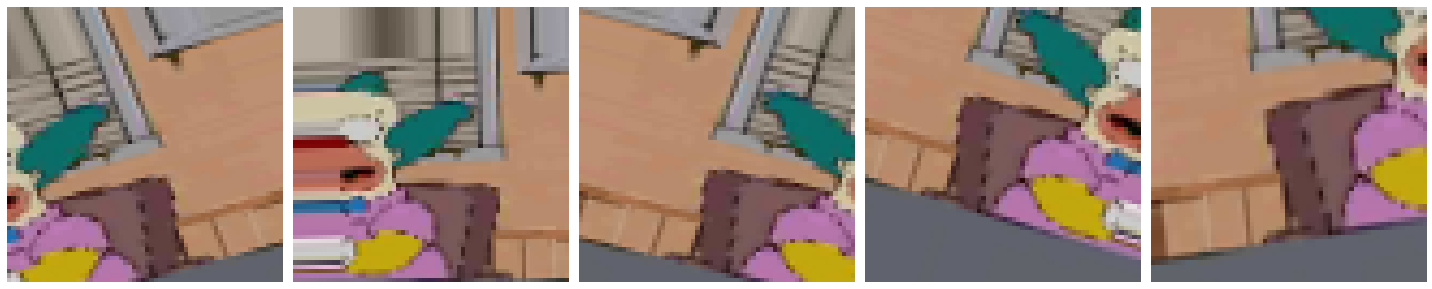

In [34]:
augmented_images = [data_train_gen[5][0][20] for i in range(5)]
plotImages(augmented_images)

## Обучение модели

In [35]:
try:
    history = model.fit(x=data_train_gen, epochs=20, verbose=1, shuffle=True, validation_data=(X_val, y_val))
except KeyboardInterrupt:
    print('\n\nStopped')


Epoch 1/20
205/205 [==============================] - 12s 58ms/step - loss: 0.2374 - accuracy: 0.9199 - val_loss: 0.1506 - val_accuracy: 0.9492
Epoch 2/20
205/205 [==============================] - 12s 57ms/step - loss: 0.2237 - accuracy: 0.9233 - val_loss: 0.1811 - val_accuracy: 0.9465
Epoch 3/20
205/205 [==============================] - 12s 56ms/step - loss: 0.2188 - accuracy: 0.9269 - val_loss: 0.1737 - val_accuracy: 0.9479
Epoch 4/20
205/205 [==============================] - 11s 56ms/step - loss: 0.2204 - accuracy: 0.9250 - val_loss: 0.1373 - val_accuracy: 0.9561
Epoch 5/20
205/205 [==============================] - 12s 61ms/step - loss: 0.2344 - accuracy: 0.9213 - val_loss: 0.1379 - val_accuracy: 0.9575
Epoch 6/20
 34/205 [===>..........................] - ETA: 10s - loss: 0.1988 - accuracy: 0.9329

Stopped


## Проверка качества модели 

- Посмотрем на основные метрики для классификации на валидационном сете

In [36]:
import sklearn
from sklearn.metrics import classification_report

print('\n', sklearn.metrics.classification_report(np.argmax(y_val, axis=1), 
                                                  np.argmax(model.predict(X_val), axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                        precision    recall  f1-score   support

abraham_grampa_simpson       0.97      0.91      0.94       104
          bart_simpson       0.94      0.94      0.94       135
                 homer       0.94      0.99      0.96       207
      krusty_the_clown       0.98      0.99      0.99       112
          lisa_simpson       0.98      0.95      0.97       152
        maggie_simpson       0.91      0.91      0.91        11
         marge_simpson       0.86      0.75      0.80         8

              accuracy                           0.96       729
             macro avg       0.94      0.92      0.93       729
          weighted avg       0.96      0.96      0.96       729



## Сохрание весов

In [37]:
#model.save('../input/weightsbesthdf5/model_8classes_als.h5')
model.save('model_7classes_als.h5')

## Проверим модель на тестовом наборе данных

- Загрузим тестовый сет и посмотрим на метрики

In [ ]:
#Для загрузки нашей модели
#model = keras.models.load_model('../input/simpsons-train-numpy-my/model_7classes_als.h5')

In [38]:
X_test, y_test = load_data_from_np('../input/simpsons-train-numpy-my/np_images/test',
                                  ['bart_simpson', 'marge_simpson', 'lisa_simpson', 'krusty_the_clown',
                                             'homer', 'abraham_grampa_simpson', 'maggie_simpson'])
y_test = ohe.transform(y_test.reshape(-1, 1))

lisa_simpson              Total time: 0.004786
bart_simpson              Total time: 0.008880
marge_simpson             Total time: 0.012836
homer                     Total time: 0.017050
maggie_simpson            Total time: 0.020715
krusty_the_clown          Total time: 0.026171
abraham_grampa_simpson    Total time: 0.030049

Done


In [39]:
print('\n', sklearn.metrics.classification_report(np.argmax(y_test, axis=1), 
                                                  np.argmax(model.predict(X_test), axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                        precision    recall  f1-score   support

abraham_grampa_simpson       0.94      0.58      0.71        26
          bart_simpson       0.92      0.81      0.86        73
                 homer       0.76      0.96      0.85        50
      krusty_the_clown       0.81      1.00      0.89        50
          lisa_simpson       0.73      0.96      0.83        50
        maggie_simpson       1.00      0.89      0.94        64
         marge_simpson       1.00      0.74      0.85        58

              accuracy                           0.86       371
             macro avg       0.88      0.85      0.85       371
          weighted avg       0.89      0.86      0.86       371



## Изобразим предсказания на тестовом сете 

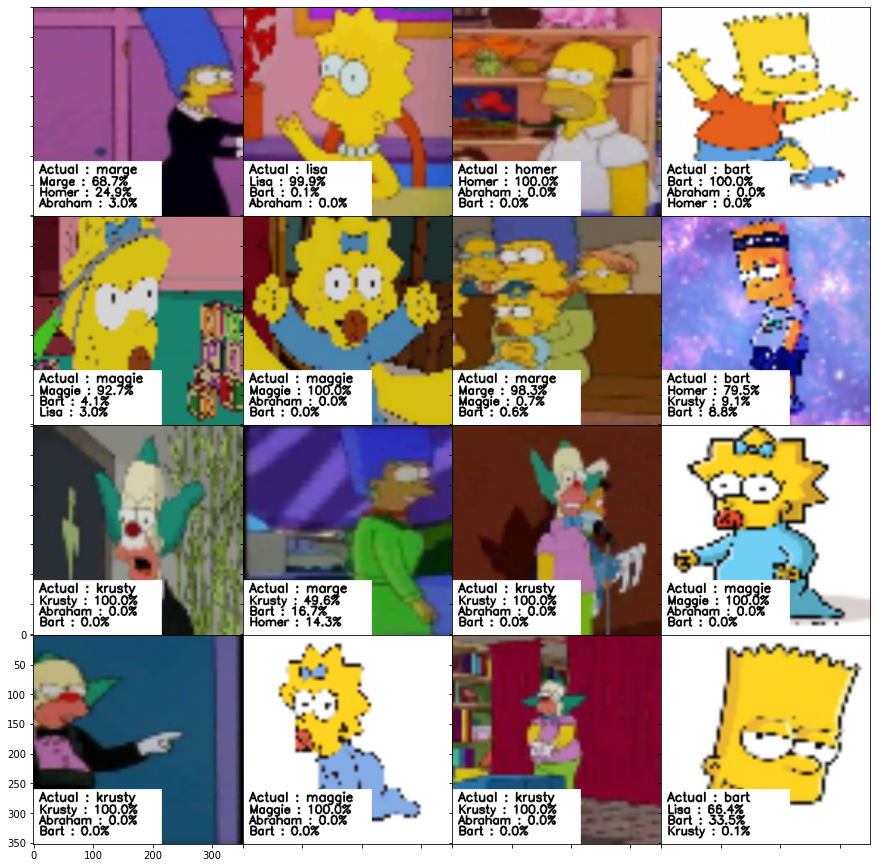

In [40]:
from mpl_toolkits.axes_grid1 import AxesGrid
import cv2

F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")

for i in range(16):
    n = np.random.choice(X_test.shape[0])

    img = X_test[n]
    a = model.predict(img.reshape(1, 64, 64,3))[0]
    
    actual = map_characters[np.argmax(y_test[n])].split('_')[0]

    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)

## Изобразим предсказания на тесте представителей каждого класса

In [41]:
TEST_PATH = '../input/simpsons-train-numpy-my/simpsons_test_set_8_classes'

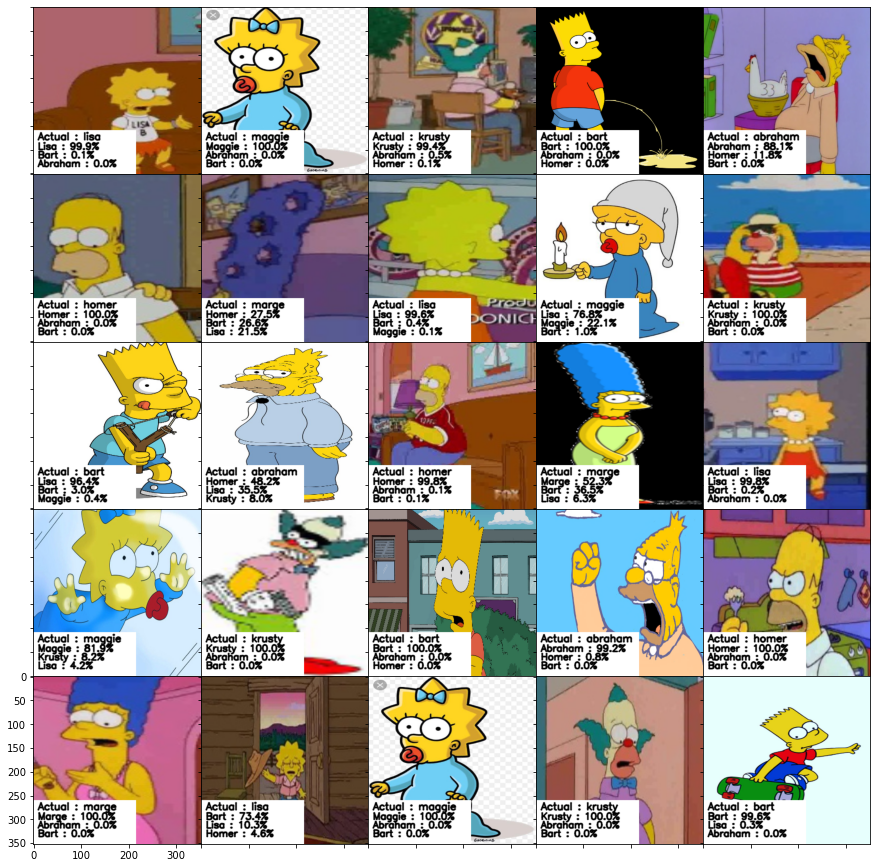

In [42]:
F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(5, 5), axes_pad=0, label_mode="1")

for i in range(25):
    class_path = glob.glob(TEST_PATH + '/*')[i%n_classes]
    img = cv2.imread(np.random.choice(glob.glob(class_path + '/*')))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    temp = cv2.resize(img,(64,64)).astype('float32') / 255.
    img = cv2.resize(img, (352, 352))
    
    a = model.predict(temp.reshape(1, 64, 64,3))[0]
    actual = class_path.split('/')[-1].split('_')[0]
    
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)

    grid[i].imshow(img)